ChEn-3170: Computational Methods in Chemical Engineering Fall 2018 UMass Lowell; Prof. V. F. de Almeida **28Nov2018**

# 14. Single Reaction at Equilibrium
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{x}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\abs}[1]{\left\lvert{#1}\right\rvert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \DeclareMathOperator{\gradx}{\nabla\!_{\xvec}}
  \newcommand{\Kcal}{\mathcal{K}}
$

---
## Table of Contents
* [Introduction](#intro)
* [Algorithm](#algo)
* [Input Data 1](#data1)
 - [Plot Equilibrium Function](#pef1)
 - [Solve for Equilibrium](#solve1)
 - [Plot Equilibrium Point](#pep1)
* [Input Data 2](#data2)
 - [Plot Equilibrium Function](#pef2)
 - [Solve for Equilibrium](#solve2)
 - [Plot Equilibrium Point](#pep2)
* [Input Data 3](#data3)
 - [Plot Equilibrium Function](#pef3)
 - [Solve for Equilibrium](#solve3)
 - [Plot Equilibrium Point](#pep3)
---

## Introduction<a id="intro"></a>
Newton's method for computing roots of a single non-linear equation, $\Kcal\bigl(\xvec(\widehat{\varepsilon})\bigr)=0$, is described in the course notes OneNote [ChEn-3170-nonlinalg-b](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EryPtVKmeq5IvTCRo66fuK4BTgwA-8Ci8wvvu3FwnKI_yA?e=TnWR4u).

The application at hand is to compute the equilibrium molar fraction of species undergoing a reversible reaction, say

\begin{equation*}
\nu_A\,\text{A} + \nu_B\,\text{B} \overset{K_x}{\longleftrightarrow} \nu_C\,\text{C} + \nu_D\,\text{D}    ,
\end{equation*}

that is, compute $x_A$, $x_B$, $x_C$, $x_D$ for the given stoichiometry and molar equilibrium reaction constant $K_x$. Note that this information is not sufficient for computing the equilibrium molar fraction. In addition, it is required that the molar fraction of **any three species is known** at some point in time or as a reference, say $x_{A_0}$, $x_{B_0}$, and $x_{C_0}$; note $x_{A_0} + x_{B_0} + x_{C_0} + x_{D_0}= 1$.

In this case we write the equilibrium function as

\begin{equation*}
\Kcal\bigl(\xvec\bigr)= K_x - \prod\limits_{j=\text{A,B,C,D}}\, x_j^{S_{1,j}} = 0,
\end{equation*}

where the molar fraction vector is defined as $\xvec = (x_A, x_B, x_C, x_c)$, the first row of elements of the stoichiometric matrix is denoted as ${S_{1,j}}$. This form of the equilibrium equation holds for any reversible chemical reaction by extending the product of powers of the molar fractions.

In [1]:
'''Equilibrium function'''

def keq_function( x_vec, eq_kx_cte, stoic_row ):
    
    value = eq_kx_cte - x_vec[0]**stoic_row[0] * x_vec[1]**stoic_row[1] \
                        * x_vec[2]**stoic_row[2] * x_vec[3]**stoic_row[3]
    
    return value

The molar fractions vector are a function of the normalized extent of reaction

\begin{equation*}
\xvec(\widehat{\varepsilon}) = \frac{\xvec^{(0)} + \widehat{\varepsilon}\,\Smtrx_{1,\bullet}}{1+\widehat{\varepsilon}\sum\limits_j S_{1,j}} ,
\end{equation*}

where $\xvec^{(0)} = (x_{A_0}, x_{B_0}, x_{C_0}, x_{D_0})$.

In [2]:
'''Molar fractions function'''

def molar_fractions( ext_hat, x_vec_0, stoic_row):
    
    assert abs(x_vec_0.sum()-1.0) <= 1e-10
    assert abs( 1.0 + ext_hat * stoic_row.sum() ) >= 1e-8
    
    x_vec = ( x_vec_0 + ext_hat * stoic_row ) / \
            ( 1.0 + ext_hat * stoic_row.sum() )
    
    return x_vec

The usage of Newton's method to compute an equilibrium molar fraction solution requires the value of 
$\Kcal\bigl(\xvec(\widehat{\varepsilon})\bigr)$ at different values of $\widehat{\varepsilon}$ and the total derivative

\begin{equation*}
d_{\widehat{\varepsilon}} \Kcal\bigl(\xvec(\widehat{\varepsilon})\bigr) = 
                       \gradx\Kcal \cdot d_{\widehat{\varepsilon}}\xvec
\end{equation*}

where the molar fraction gradient is 

\begin{equation*}
 \gradx\Kcal = - 
  K_x \begin{pmatrix} 
       S_{1,A}\,x_A^{-1} \\ 
       S_{1,B}\,x_B^{-1} \\
       S_{1,C}\,x_C^{-1} \\
       S_{1,D}\,x_D^{-1} 
       \end{pmatrix} .
\end{equation*}

In [3]:
'''Gradient wrt molar fractions of the equilibrium function'''

def grad_x_k_function( x_vec, eq_kx_cte, stoic_row ):
    
    # correct for division by a very small number
    import numpy as np
    x_vec_local = np.copy(x_vec)
    
    max_x = x_vec_local.max()
    for i in range(x_vec_local.size):
        if x_vec_local[i] < 1e-8:
            x_vec_local[i] = max_x # some reasonable mole fraction
            
    x_vec_inv = 1.0/x_vec_local
    
    grad_vec = -eq_kx_cte * stoic_row*x_vec_inv
    
    return grad_vec

The molar fraction derivative is

\begin{equation*}
  d_{\widehat{\varepsilon}}\xvec = \frac{\Smtrx_{1,j} - \xvec^{(0)}\,\sum_j S_{1,j}}
                                { \bigl(1 + \widehat{\varepsilon}\,\sum_j S_{1,j}\bigr)^2 } .
\end{equation*}


In [4]:
'''Derivative of the molar fractions function wrt normalized extent of reaction'''

def d_ext_molar_fractions( ext_hat, x_vec_0, stoic_row ):
    
    dext_x_vec = ( stoic_row - x_vec_0 * stoic_row.sum() ) / \
                 ( 1.0 + ext_hat * stoic_row.sum() )**2
    
    return dext_x_vec

## Algorithm<a id="algo"></a>

Given $\Kcal\bigl(\xvec(\widehat{\varepsilon})\bigr)$, find the root

\begin{equation*}
\Kcal\bigl(\xvec(\widehat{\varepsilon})\bigr) = 0 ,
\end{equation*}

using an iterative method based on the initial guess $\widehat{\varepsilon}_0$. Compute the updates

\begin{equation*}
\delta \widehat{\varepsilon}_k = - \frac{ \Kcal\bigl(\xvec(\widehat{\varepsilon}_{k-1})\bigr)}
                                     {d_{\widehat{\varepsilon}}\Kcal\bigl(\xvec(\widehat{\varepsilon}_{k-1})\bigr)} 
                                     \ \qquad \  \forall \ \qquad \ k = 1,\ldots,k_\text{max} , 
\end{equation*}

then compute the approximation to the root

\begin{equation*}
 \widehat{\varepsilon}_k = \widehat{\varepsilon}_{k-1} + \delta \widehat{\varepsilon}_k \ \qquad \  \forall \ \qquad\ \ k = 1,\ldots,k_\text{max} ,
\end{equation*}

until convergence, say, $\abs{\delta\widehat{\varepsilon}_k} \le 10^{-8}$ and $\abs{\Kcal\bigl(\xvec(\widehat{\varepsilon}_k)\bigr)} \le 10^{-8}$, or no convergence achieved , say $k>k_\text{max}$. 

In [5]:
"""Newton's method"""

def newton_solve( x_vec_0, eq_kx_cte, stoic_row,
                  ext_hat_0=0.0, k_max=30, tolerance=1.0e-10, verbose=True ):

    # Other initialization
    delta_k = 1e+10
    keq_k   = 1e+10     # equilibrium function initial value
    ext_hat = ext_hat_0

    if verbose is True:
        print('\n')
        print('******************************************************')
        print("          Newton's Method Iterations                  ")
        print('******************************************************')
        print("k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|")
        print('------------------------------------------------------')

    import math
    k = 0
    
    while (abs(delta_k) > tolerance or abs(keq_k) > tolerance) and k <= k_max:
        
        # compute the molar fractions
        x_vec = molar_fractions( ext_hat, x_vec_0, stoic_row ) 
        
        # compute the equilibrium function
        keq_k   = keq_function( x_vec, eq_kx_cte, stoic_row )
        
        # copute the molar fraction gradient of the equilibrium function
        grad_x_k = grad_x_k_function( x_vec, eq_kx_cte, stoic_row )
        
        # compute the extent of reaction derivative of the molar fraction
        d_ext_x = d_ext_molar_fractions( ext_hat, x_vec_0, stoic_row )
        
        # form the total derivative of the equilibrium function wrt the extent of reaction
        d_ext_keq_k = grad_x_k @ d_ext_x
        
        # compute the Newton update    
        delta_k_old = delta_k
        delta_k = - keq_k / d_ext_keq_k
        
        # compute the update to the root candidate
        ext_hat += delta_k
        
        if k > 0:
            if delta_k != 0.0 and delta_k_old != 0.0:
                convergence_factor = math.log(abs(delta_k),10) / math.log(abs(delta_k_old),10)
            else:
                convergence_factor = 0.0  
        else:
            convergence_factor = 0.0
            
        k = k + 1
        
        if verbose is True:
            print('%2i %+5.3e %+5.3e %+5.3e  %+5.3e %5.2f'%\
                  (k,keq_k,d_ext_keq_k,abs(delta_k),ext_hat,convergence_factor))

    if verbose is True:
        print('******************************************************') 
        print('Root = %8.5e'%ext_hat)
    
    return ext_hat

## Input Data 1<a id="data1"></a>

Reversible reaction: 
$\nu_A\,\text{A} + \nu_B\,\text{B} \overset{K_x}{\longleftrightarrow} \nu_C\,\text{C} + \nu_D\,\text{D}$ 

Name                        | Parameter    | Value | Name     | Parameter | Value |
----------------------------|--------------|-------|----------|-----------|-------|
initial molar fraction of A  | $x_{A_0}$    | 0.5   | stoic. A | $\nu_A$   |  0.7  |
initial molar fraction of B  | $x_{B_0}$    | 0.5   | stoic. B | $\nu_B$   |  1.3  |
initial molar fraction of C  | $x_{C_0}$    | 0.0   | stoic. C | $\nu_C$   |  1.7  |
initial molar fraction of C  | $x_{D_0}$    | 0.0   | stoic. D | $\nu_D$   |  0.5  |
molar equilibrium constant   | $K_\text{x}$ | 108   |          |           |       |

In [6]:
'''Parameters for chemical equilibrium of A + B <-> C + D'''

x_a_0 = 0.5
x_b_0 = 0.5
x_c_0 = 0.
x_d_0 = 0.

species_names = ['A','B','C','D']

import numpy as np
stoic_row = np.array([-0.7, -1.3, 1.7, 0.5])

reaction =  str(-stoic_row[0])+' A + '+str(-stoic_row[1])+' B '\
           +' <=> '\
           +str(stoic_row[2])+' C + '+str(stoic_row[3])+' D '

x_vec_0 = np.array([x_a_0, x_b_0, x_c_0, x_d_0])

assert abs(np.sum(x_vec_0) - 1.0) <= 1e-12
assert np.all(x_vec_0 >=0.0)

eq_kx_cte = 108.0

print('reaction: ',reaction)

reaction:  0.7 A + 1.3 B  <=> 1.7 C + 0.5 D 


In [7]:
'''Function: plot K equilibrium function'''

def plot_keq_function( ex_min, ex_max, n_pts,
                   x_vec_0, eq_kx_cte, stoic_row,
                   ext_hat_root=None  ):
    
    import matplotlib.pyplot as plt
    plt.figure(1, figsize=(6, 6))
    
    import numpy as np
    ex_vec = np.linspace(ex_min, ex_max, n_pts)
    
    keq_function_values = list()
    for e in ex_vec:
        x_vec = molar_fractions( e, x_vec_0, stoic_row ) 
        keq_function_values.append( keq_function( x_vec, eq_kx_cte, stoic_row) ) 
    
    plt.plot(ex_vec, keq_function_values,'b-',label='$K_{eq}$')
    
    plt.xlabel(r'$\hat{\varepsilon}$',fontsize=18)
    plt.ylabel(r'$K(\hat{\varepsilon})$',fontsize=18)
    plt.title(reaction,fontsize=20)
    #plt.legend(loc='best',fontsize=12)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    (x_min,x_max) = plt.xlim()
    dx = abs(x_max-x_min)
    x_text = (x_max+x_min)/2
    
    (y_min,y_max) = plt.ylim()
    dy = abs(y_max-y_min)
    y_text = y_max - dy*0.05
    
    for x,spc in zip(x_vec_0,species_names):
        
        plt.text(x_text, y_text, 'x_%s_0=%8.2e'%(spc,x),fontsize=16)
        y_text -= dy*0.06
    
    y_text -= dy*0.06
    plt.text(x_text, y_text, r'$K_x=$%8.2e'%eq_kx_cte,fontsize=16)
    
    
    if ext_hat_root is not None:
        
        plt.plot(ext_hat_root, 0.0,'r*',label='root',markersize=14)
               
        (x_min,x_max) = plt.xlim()
        dx = abs(x_max-x_min)
        x_text = ext_hat_root + dx*0.01
    
        (y_min,y_max) = plt.ylim()
        dy = abs(y_max-y_min)
        y_text = 0.0 + dy*0.01
    
        plt.text(x_text, y_text, r'$\hat{\varepsilon}^*=$%8.2e'%ext_hat_root,fontsize=16)
    
    
    plt.grid(True)
    plt.show()
    print('')
    
    return

### Plot Equilibrium Function 1<a id="pef1"></a>

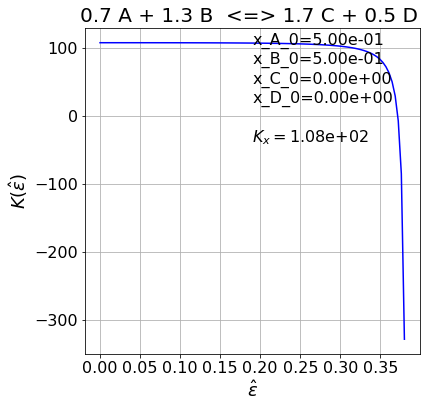

In [9]:
'''Plot equilibrium function'''

ext_hat_min = 0.0
ext_hat_max = 0.38
n_pts = 100
plot_keq_function( ext_hat_min, ext_hat_max, n_pts, 
                   x_vec_0, eq_kx_cte, stoic_row )

### Solve for Equilibrium 1<a id="solve1"></a>

In [11]:
'''Find root and equilibrium molar fractions'''

ext_hat_0 = 0.0
k_max = 20
tolerance = 1.0e-8

ext_hat = newton_solve( x_vec_0, eq_kx_cte, stoic_row,
                        ext_hat_0, k_max, tolerance )

x_vec = molar_fractions( ext_hat, x_vec_0, stoic_row )

print('')
print('Equilibrium mole fractions:\n')
for (x,spc) in zip(x_vec,species_names):
    print('x_%s = %5.3e\n'%(spc,x))
    
assert np.all(x_vec >= 0.0)
assert abs(x_vec.sum() - 1.0) <= 1e-10



******************************************************
          Newton's Method Iterations                  
******************************************************
k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|
------------------------------------------------------
 1 +1.080e+02 -1.192e+03 +9.058e-02  +9.058e-02  0.00
 2 +1.079e+02 -3.218e+03 +3.355e-02  +1.241e-01  1.41
 3 +1.079e+02 -2.577e+03 +4.186e-02  +1.660e-01  0.93
 4 +1.077e+02 -2.207e+03 +4.878e-02  +2.148e-01  0.95
 5 +1.071e+02 -2.080e+03 +5.150e-02  +2.663e-01  0.98
 6 +1.056e+02 -2.243e+03 +4.707e-02  +3.133e-01  1.03
 7 +1.008e+02 -2.912e+03 +3.462e-02  +3.479e-01  1.10
 8 +8.516e+01 -4.714e+03 +1.806e-02  +3.660e-01  1.19
 9 +4.413e+01 -8.409e+03 +5.248e-03  +3.713e-01  1.31
10 +5.544e+00 -1.137e+04 +4.877e-04  +3.717e-01  1.45
11 +5.155e-02 -1.177e+04 +4.381e-06  +3.718e-01  1.62
12 +4.177e-06 -1.177e+04 +3.549e-10  +3.718e-01  1.76
13 +5.684e-14 -1.177e+04 +4.829e-18  +3.718e-01  1.83
*********************

### Plot Equilibrium Point 1<a id="pep1"></a>

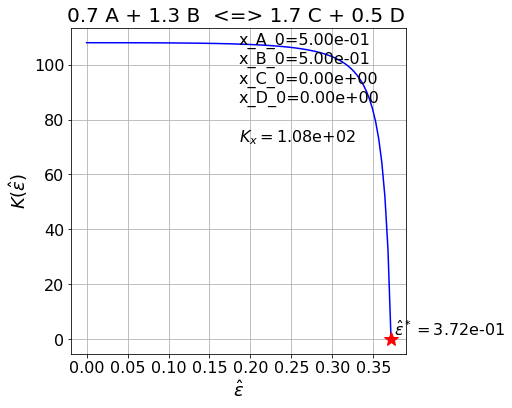

In [12]:
'''Plot equilibrium function with root'''

ext_hat_min = 0.0
ext_hat_max = ext_hat 
n_pts = 100
plot_keq_function( ext_hat_min, ext_hat_max, n_pts, 
                   x_vec_0, eq_kx_cte, stoic_row, ext_hat )

## Input Data 2<a id="data2"></a>

Reversible reaction: 
$\nu_A\,\text{A} + \nu_B\,\text{B} \overset{K_x}{\longleftrightarrow} \nu_C\,\text{C} + \nu_D\,\text{D}$ 

Name                        | Parameter    | Value | Name     | Parameter | Value |
----------------------------|--------------|-------|----------|-----------|-------|
initial mole fraction of A  | $x_{A_0}$    | 0.22  | stoic. A | $\nu_A$   |  0.7  |
initial mole fraction of B  | $x_{B_0}$    | 0.51  | stoic. B | $\nu_B$   |  1.3  |
initial mole fraction of C  | $x_{C_0}$    | 0.17  | stoic. C | $\nu_C$   |  1.7  |
initial mole fraction of C  | $x_{D_0}$    | 0.10  | stoic. D | $\nu_D$   |  0.5  |
mole equilibrium constant   | $K_\text{x}$ | 108   |          |           |       |

In [13]:
'''Parameters for chemical equilibrium of A + B <-> C + D'''

x_a_0 = 0.22
x_b_0 = 0.51
x_c_0 = 0.17
x_d_0 = 0.10

species_names = ['A','B','C','D']

import numpy as np
stoic_row = np.array([-0.7, -1.3, 1.7, 0.5])

reaction =  str(-stoic_row[0])+' A + '+str(-stoic_row[1])+' B '\
           +' <=> '\
           +str(stoic_row[2])+' C + '+str(stoic_row[3])+' D '

x_vec_0 = np.array([x_a_0, x_b_0, x_c_0, x_d_0])

assert abs(np.sum(x_vec_0) - 1.0) <= 1e-12
assert np.all(x_vec_0 >=0.0)

eq_kx_cte = 108.0

print('reaction: ',reaction)

reaction:  0.7 A + 1.3 B  <=> 1.7 C + 0.5 D 


### Plot Equilibrium Function 2<a id="pef2"></a>

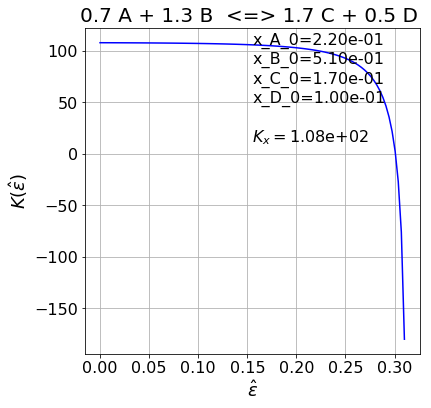

In [14]:
'''Plot equilibrium function'''

ext_hat_min = 0.0
ext_hat_max = 0.31
n_pts = 100
plot_keq_function( ext_hat_min, ext_hat_max, n_pts, 
                   x_vec_0, eq_kx_cte, stoic_row )

### Solve for Equilibrium 2<a id="solve2"></a>

In [15]:
'''Find root and equilibrium molar fractions'''

ext_hat_0 = 0.0
k_max = 20
tolerance = 1.0e-8

ext_hat = newton_solve( x_vec_0, eq_kx_cte, stoic_row,
                        ext_hat_0, k_max, tolerance )

x_vec = molar_fractions( ext_hat, x_vec_0, stoic_row )

print('')
print('Equilibrium mole fractions:\n')
for (x,spc) in zip(x_vec,species_names):
    print('x_%s = %5.3e\n'%(spc,x))

assert np.all(x_vec >= 0.0)
assert abs(x_vec.sum() - 1.0) <= 1e-10



******************************************************
          Newton's Method Iterations                  
******************************************************
k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|
------------------------------------------------------
 1 +1.079e+02 -2.700e+03 +3.996e-02  +3.996e-02  0.00
 2 +1.077e+02 -2.207e+03 +4.882e-02  +8.878e-02  0.94
 3 +1.073e+02 -1.953e+03 +5.495e-02  +1.437e-01  0.96
 4 +1.062e+02 -1.914e+03 +5.549e-02  +1.992e-01  1.00
 5 +1.031e+02 -2.129e+03 +4.841e-02  +2.476e-01  1.05
 6 +9.363e+01 -2.749e+03 +3.405e-02  +2.817e-01  1.12
 7 +6.718e+01 -4.178e+03 +1.608e-02  +2.978e-01  1.22
 8 +2.018e+01 -6.629e+03 +3.044e-03  +3.008e-01  1.40
 9 +6.209e-01 -7.708e+03 +8.055e-05  +3.009e-01  1.63
10 +3.848e-04 -7.743e+03 +4.970e-08  +3.009e-01  1.78
11 +1.457e-10 -7.743e+03 +1.882e-14  +3.009e-01  1.88
******************************************************
Root = 3.00895e-01

Equilibrium mole fractions:

x_A = 8.842e-03

x_B = 1.

### Plot Equilibrium Point 2<a id="pep2"></a>

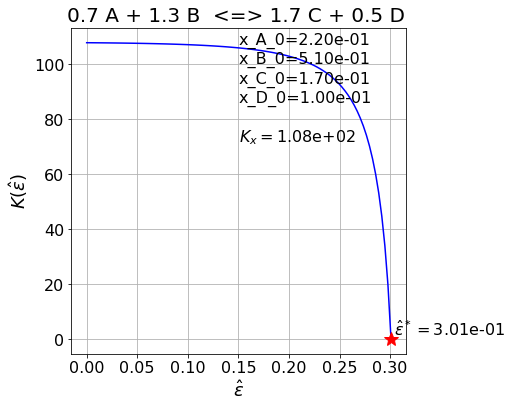

In [16]:
'''Plot equilibrium function with root'''

ext_hat_min = 0.0
ext_hat_max = ext_hat 
n_pts = 100
plot_keq_function( ext_hat_min, ext_hat_max, n_pts, 
                   x_vec_0, eq_kx_cte, stoic_row, ext_hat )

## Input Data 3<a id="data3"></a>

Reversible reaction: 
$\nu_A\,\text{A} + \nu_B\,\text{B} \overset{K_x}{\longleftrightarrow} \nu_C\,\text{C} + \nu_D\,\text{D}$ 

Name                        | Parameter    | Value | Name     | Parameter | Value |
----------------------------|--------------|-------|----------|-----------|-------|
initial mole fraction of A  | $x_{A_0}$    | 0.07  | stoic. A | $\nu_A$   |  1.7  |
initial mole fraction of B  | $x_{B_0}$    | 0.11  | stoic. B | $\nu_B$   |  2.3  |
initial mole fraction of C  | $x_{C_0}$    | 0.32  | stoic. C | $\nu_C$   |  0.2  |
initial mole fraction of C  | $x_{D_0}$    | 0.50  | stoic. D | $\nu_D$   |  1.5  |
mole equilibrium constant   | $K_\text{x}$ | 120   |          |           |       |

In [17]:
'''Parameters for chemical equilibrium of A + B <-> C + D'''

x_a_0 = 0.07
x_b_0 = 0.11
x_c_0 = 0.32
x_d_0 = 0.50

species_names = ['A','B','C','D']

import numpy as np
stoic_row = np.array([-1.7, -2.3, 0.2, 1.5])

reaction =  str(-stoic_row[0])+' A + '+str(-stoic_row[1])+' B '\
           +' <=> '\
           +str(stoic_row[2])+' C + '+str(stoic_row[3])+' D '

x_vec_0 = np.array([x_a_0, x_b_0, x_c_0, x_d_0])

assert abs(np.sum(x_vec_0) - 1.0) <= 1e-12
assert np.all(x_vec_0 >=0.0)

eq_kx_cte = 120.0

print('reaction: ',reaction)

reaction:  1.7 A + 2.3 B  <=> 0.2 C + 1.5 D 


### Plot Equilibrium Function 3<a id="pef3"></a>

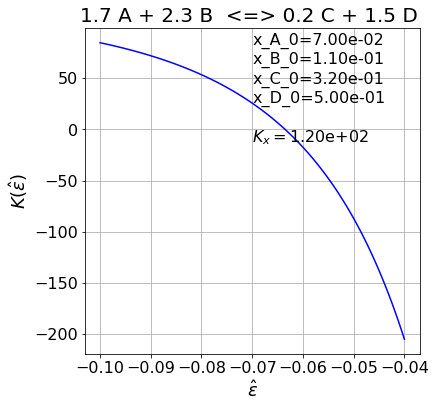

In [18]:
'''Plot equilibrium function'''

ext_hat_min = -0.1
ext_hat_max = -0.04
n_pts = 100
plot_keq_function( ext_hat_min, ext_hat_max, n_pts, 
                   x_vec_0, eq_kx_cte, stoic_row )

### Solve for Equilibrium 3<a id="solve3"></a>

In [19]:
'''Find root and equilibrium molar fractions'''

ext_hat_0 = -0.3
k_max = 20
tolerance = 1.0e-8

ext_hat = newton_solve( x_vec_0, eq_kx_cte, stoic_row,
                        ext_hat_0, k_max, tolerance )

x_vec = molar_fractions( ext_hat, x_vec_0, stoic_row )

print('')
print('Equilibrium mole fractions:\n')
for (x,spc) in zip(x_vec,species_names):
    print('x_%s = %5.3e\n'%(spc,x))
    
assert np.all(x_vec >= 0.0)
assert abs(x_vec.sum() - 1.0) <= 1e-10



******************************************************
          Newton's Method Iterations                  
******************************************************
k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|
------------------------------------------------------
 1 +1.199e+02 -6.434e+03 +1.863e-02  -2.814e-01  0.00
 2 +1.197e+02 -4.568e+03 +2.621e-02  -2.552e-01  0.91
 3 +1.193e+02 -3.520e+03 +3.391e-02  -2.212e-01  0.93
 4 +1.184e+02 -3.006e+03 +3.938e-02  -1.819e-01  0.96
 5 +1.158e+02 -2.874e+03 +4.028e-02  -1.416e-01  0.99
 6 +1.086e+02 -3.050e+03 +3.562e-02  -1.060e-01  1.04
 7 +9.026e+01 -3.478e+03 +2.595e-02  -8.002e-02  1.09
 8 +5.333e+01 -4.032e+03 +1.323e-02  -6.679e-02  1.18
 9 +1.378e+01 -4.438e+03 +3.104e-03  -6.369e-02  1.34
10 +6.835e-01 -4.550e+03 +1.502e-04  -6.354e-02  1.52
11 +1.535e-03 -4.555e+03 +3.369e-07  -6.354e-02  1.69
12 +7.697e-09 -4.555e+03 +1.690e-12  -6.354e-02  1.82
******************************************************
Root = -6.35380e-02


**Note negative extent of reaction at equilibrium. Compare the equilibrium molar fractions to the initial equilibrium molar fractions.**

### Plot Equilibrium Point 3<a id="pep3"></a>

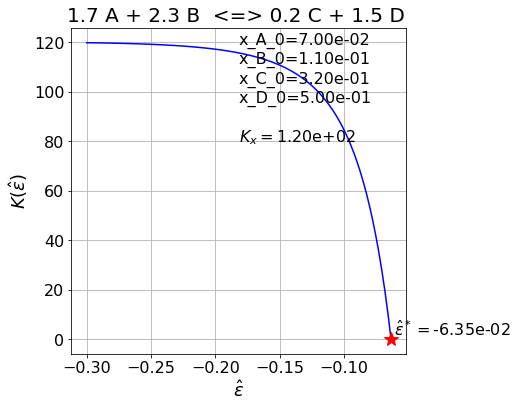

In [20]:
'''Plot equilibrium function with root'''

ext_hat_min = -0.3
ext_hat_max = ext_hat 
n_pts = 100
plot_keq_function( ext_hat_min, ext_hat_max, n_pts, 
                   x_vec_0, eq_kx_cte, stoic_row, ext_hat )